# Final Project - DSI

    - Introduction of the given Task
    - Walkthrough of the Project / Notebook
    - Summary and Conclusion
    - Whats next? - Recommendation for folow up Projects
    

## Predictive Quality - Production of roastied coffee

### About Dataset:
Context:

You need to build a model that, on the basis of data arriving every minute, determines the quality of products produced on a roasting machine.

Content:

The roasting machine is an aggregate consisting of 5 chambers of equal size, each chamber has 3 temperature sensors. In addition, for this task, you have collected data on the height of the raw material layer and its moisture content. Layer height and humidity are measured when raw materials enter the machine. Raw materials pass through the kiln in an hour.

Acknowledgements:

Product quality is measured in the laboratory by samples that are taken every hour, data on known analyzes are contained in the file data_Y.csv. The file indicates the time of sampling, the sample is taken at the exit of the roasting machine.

Inspiration:

You agreed with the customer that the model will be estimated by the MAE indicator, to evaluate the model, it is necessary to generate predictions for the period specified in the file sample_submission.csv (5808 predictions).

![Alt text](1200_675_crop.jpg)

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


# Load the data
X = pd.read_csv('data_X.csv')
Y = pd.read_csv('data_Y.csv')
S = pd.read_csv('sample_submission.csv')


![Alt text](Visualisation_Prozessflow.png)

# Descriptive Analysis (DA)

In this chapter we´ll try to get a better "feeling" for the given Data. 

For example, Look if the data has
- inplausible, 
- missing,
- not applicable 

values.
    



In [2]:
# Get a overview of the data
X.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [3]:
# Check for missing values
X.isnull().sum()

date_time     0
T_data_1_1    0
T_data_1_2    0
T_data_1_3    0
T_data_2_1    0
T_data_2_2    0
T_data_2_3    0
T_data_3_1    0
T_data_3_2    0
T_data_3_3    0
T_data_4_1    0
T_data_4_2    0
T_data_4_3    0
T_data_5_1    0
T_data_5_2    0
T_data_5_3    0
H_data        0
AH_data       0
dtype: int64

In [4]:
# Get an overview of Label data
print("Y Kopfzeilen:")
print(Y.head(), "\n")
print("Y Fußzeilen") 
print(Y.tail(), "\n")
print("S Kopfzeilen:") 
print(S.head())
# Look like the Timestamp of the Label start 4 dayes after the Timestamp of the Features 
# The Timestamp of S start right after the Timestamp of Y -> Given Train and Test labels

Y Kopfzeilen:
             date_time  quality
0  2015-01-04 00:05:00      392
1  2015-01-04 01:05:00      384
2  2015-01-04 02:05:00      393
3  2015-01-04 03:05:00      399
4  2015-01-04 04:05:00      400 

Y Fußzeilen
                 date_time  quality
29179  2018-05-03 19:05:00      438
29180  2018-05-03 20:05:00      452
29181  2018-05-03 21:05:00      455
29182  2018-05-03 22:05:00      455
29183  2018-05-03 23:05:00      454 

S Kopfzeilen:
             date_time  quality
0  2018-05-04 00:05:00      420
1  2018-05-04 01:05:00      420
2  2018-05-04 02:05:00      420
3  2018-05-04 03:05:00      420
4  2018-05-04 04:05:00      420


In [5]:
# Data Shapes
print("X Shape: ", X.shape)
print("Y Shape: ", Y.shape)
print("S Shape: ", S.shape)

X Shape:  (2103841, 18)
Y Shape:  (29184, 2)
S Shape:  (5808, 2)


In [6]:
# Check how many Datapoints in X have no Label (whether in Y or S)
print(f'Datarows without Lable\nX / 60 - (Y+S):\n{(X.shape[0]/60 - Y.shape[0] - S.shape[0]):.2f} ') # /60 because we have 60 minutes in an hour and the lable of the data is per hour

Datarows without Lable
X / 60 - (Y+S):
72.02 


In [7]:
# Check "data_time" Datatype
print(type(X.loc[0, 'date_time']))
print(type(Y.loc[0, 'date_time']))
print(type(S.loc[0, 'date_time']))

<class 'str'>
<class 'str'>
<class 'str'>


In [8]:
# Description of the X data
X.describe()
# The mean and median (middle quartile) of the features are very close to each other, which means that the data is not skewed.
# I asume the mean should represent the set temperature of the roasting machine.
# The standard deviation is in a respectable range of the set Temperature.
# But the min and max values are devieting to mutch from a realistic temperature range. Especially the negative min values have to be checked.

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
count,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06,2.103841e+06
mean,2.501822e+02,2.500915e+02,2.502536e+02,3.497756e+02,3.497218e+02,3.498282e+02,5.011611e+02,5.011092e+02,5.012335e+02,3.493196e+02,3.494390e+02,3.500299e+02,2.497488e+02,2.496311e+02,2.496937e+02,1.747170e+02,7.499369e+00
std,3.211661e+01,3.082451e+01,3.069125e+01,4.225961e+01,4.067887e+01,3.798444e+01,6.325732e+01,6.337164e+01,6.223294e+01,3.930562e+01,3.919989e+01,4.018360e+01,3.073298e+01,3.050021e+01,3.074629e+01,1.443613e+01,1.148026e+00
min,-1.980000e+02,-1.220000e+02,-1.070000e+02,-7.030000e+02,-9.580000e+02,-1.910000e+02,-7.750000e+02,-7.590000e+02,-6.130000e+02,-5.140000e+02,-4.710000e+02,-6.090000e+02,-8.900000e+01,-1.250000e+02,-1.630000e+02,1.414900e+02,2.890000e+00
25%,2.290000e+02,2.290000e+02,2.290000e+02,3.280000e+02,3.280000e+02,3.280000e+02,4.640000e+02,4.640000e+02,4.640000e+02,3.270000e+02,3.280000e+02,3.280000e+02,2.290000e+02,2.290000e+02,2.290000e+02,1.624400e+02,6.730000e+00
50%,2.500000e+02,2.500000e+02,2.500000e+02,3.500000e+02,3.500000e+02,3.500000e+02,5.020000e+02,5.020000e+02,5.020000e+02,3.490000e+02,3.500000e+02,3.500000e+02,2.490000e+02,2.500000e+02,2.500000e+02,1.744000e+02,7.510000e+00
75%,2.720000e+02,2.720000e+02,2.720000e+02,3.720000e+02,3.720000e+02,3.720000e+02,5.380000e+02,5.380000e+02,5.390000e+02,3.720000e+02,3.720000e+02,3.720000e+02,2.700000e+02,2.710000e+02,2.710000e+02,1.870100e+02,8.270000e+00
max,7.240000e+02,7.620000e+02,6.650000e+02,1.302000e+03,1.179000e+03,8.890000e+02,1.587000e+03,2.505000e+03,1.319000e+03,1.177000e+03,1.244000e+03,9.440000e+02,9.050000e+02,7.380000e+02,6.240000e+02,2.078300e+02,1.184000e+01


In [9]:
# Check the other features for unrealistic values
# Due to the fact that the sensor in this example (3_2) is in the same chamber as 3_1 and 3_3, the temperature should be in a similar range.
X[X["T_data_3_2"] < 0] # -> indicates that the sensor is defect

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
282485,2015-07-16 04:05:00,283,302,283,351,337,331,463,-8,453,418,399,408,251,245,243,192.42,5.36
282486,2015-07-16 04:06:00,283,302,283,352,338,332,463,-28,453,418,399,408,251,245,243,195.35,5.36
282487,2015-07-16 04:07:00,283,302,283,352,338,332,462,-48,453,418,399,407,250,245,243,195.72,5.36
282488,2015-07-16 04:08:00,283,302,283,353,338,332,462,-67,454,418,399,407,250,244,243,193.56,5.36
282489,2015-07-16 04:09:00,283,302,283,353,338,332,462,-86,454,418,399,407,250,244,243,200.31,5.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923735,2018-08-28 22:15:00,252,242,238,334,342,348,465,-6,465,331,328,327,233,241,238,191.32,7.88
1923736,2018-08-28 22:16:00,252,242,238,334,342,348,465,-5,465,331,328,327,233,241,238,193.52,7.88
1923737,2018-08-28 22:17:00,253,242,238,334,342,348,466,-4,465,332,328,327,233,240,238,189.77,7.88
1923738,2018-08-28 22:18:00,253,242,239,334,342,348,466,-3,465,332,328,327,233,240,238,191.30,7.88


<Axes: ylabel='T_data_3_1'>

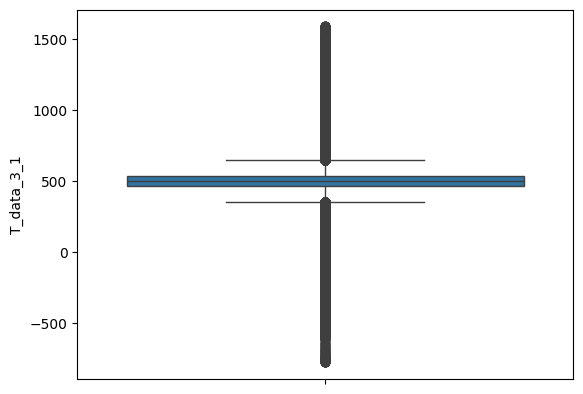

In [10]:
sns.boxplot(X['T_data_3_1'])

<Axes: ylabel='AH_data'>

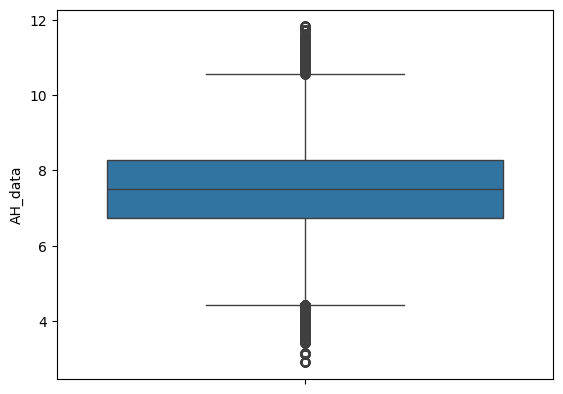

In [11]:
sns.boxplot(X['AH_data'])

# Summary of Data Analysis

## Observations:
- It appears that the timestamps for the labels begin 3 days after the timestamps for the features.
    - **Implication:** 72 hours' worth of data cannot be used due to missing labels, assuming we proceed with a supervised learning algorithm.
- The timestamps for "S" start immediately after the timestamps for "Y," which suggests a clear separation between training and testing data.
- Timestamps are currently stored as strings (`str` type).
- The mean and median (middle quartile) of the features are very close to each other, indicating that the data distribution is not skewed.
- It is assumed that the mean represents the set temperature of the roasting machine.
- The standard deviation falls within an acceptable range relative to the set temperature.
- However, the minimum and maximum values deviate significantly from a realistic temperature range. The presence of negative minimum values is particularly concerning and requires further investigation.


In [12]:
# Chreate a new feature with the hour of the day
X["date_time"] = pd.to_datetime(X["date_time"])
X["date_hour"] = X["date_time"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))

# Data Preparation Before Exploratory Data Analysis (EDA):
- Address the implausible feature values.
- Convert the `data_time` column to a usable date/time format.
- Join dataset "Y" with "X," ensuring that one row of "Y" corresponds to 60 rows of "X."
- Integrate dataset "S" with "X" to ensure consistency and completeness.

At this stage, I must decide how to address the discrepancy in the granularity of the data points. Given that labels are only provided on an hourly basis, I have three potential approaches to proceed:

1. Assign the same label to every minute within the same hour (maximum data retention).
2. Transform the dataset such that each data point within the same hour is treated as a separate set of features, resulting in a vector with 1,080 features (18x60) and one label.
3. Reduce the data points by aggregating the minute-by-minute values within each hour using the mean.

In a separate notebook, I explored option 1 but did not achieve better results compared to option 3. Therefore, I have chosen to proceed with option 3 in this analysis, significantly reducing the dataset from 2.1 million data points to approximately 35,000.

In [13]:
# Group the data by hour
X = X.groupby("date_hour").mean()
X.shape

(35065, 18)

In [14]:
# Create a Dictionary of the mean for every feature:
dict_of_mean_values = X.describe().loc['mean'].to_dict()
dict_of_std_values = X.describe().loc['std'].to_dict()

Text(0.5, 1.0, 'Statistical outliers exchanged with the mean value')

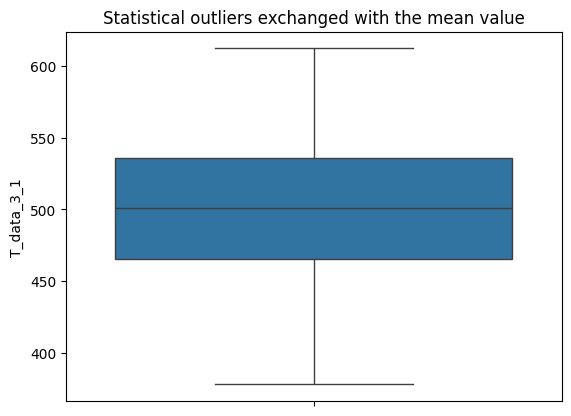

In [15]:
# Replace the values deviating 2 sigma from the mean with the mean value:
for column in X.columns[1:]:
    X.loc[X[column] < dict_of_mean_values[column] - 2*X[column].std(), column] = dict_of_mean_values[column]
    X.loc[X[column] > dict_of_mean_values[column] + 2*X[column].std(), column] = dict_of_mean_values[column]

sns.boxplot(X['T_data_3_1'])
plt.title("Statistical outliers exchanged with the mean value")

In [16]:
# Prepare the Label data
Y["date_shifted"] = pd.to_datetime(Y["date_time"]) - datetime.timedelta(hours=1)
Y["date_shifted"] = pd.to_datetime(Y["date_shifted"])
Y["date_shifted"] = Y["date_shifted"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))
Y.drop(columns=["date_time"], inplace=True)
Y.shape

(29184, 2)

In [17]:
# Prepare the Sample-Label data
S["date_shifted"] = pd.to_datetime(S["date_time"]) - datetime.timedelta(hours=1)
S["date_shifted"] = pd.to_datetime(S["date_shifted"])
S["date_shifted"] = S["date_shifted"].apply(lambda x: x.strftime("%d-%m-%Y-%H"))
S.drop(columns=["date_time"], inplace=True)
S.shape

(5808, 2)

In [18]:
# Create the Train and Test data
train = pd.merge(X,Y, left_on="date_hour", right_on="date_shifted", how="inner")
test = pd.merge(X,S, left_on="date_hour", right_on="date_shifted", how="inner")

# EDA
## Goals of the Exploratory Data Analysis:

- Look for distributions
- Correlations
- Get a even better "feeling" of the Data

Text(0.5, 1.0, 'Quality over time')

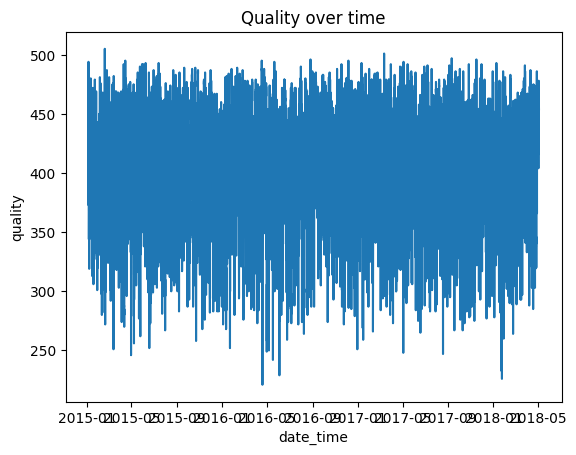

In [19]:
# Quality over time
sns.lineplot(data=train,x="date_time", y="quality")
plt.title("Quality over time")
# Amplitude of the outliers to the downside is higher than to the upside.

Text(0.5, 1.0, 'Correlation Matrix')

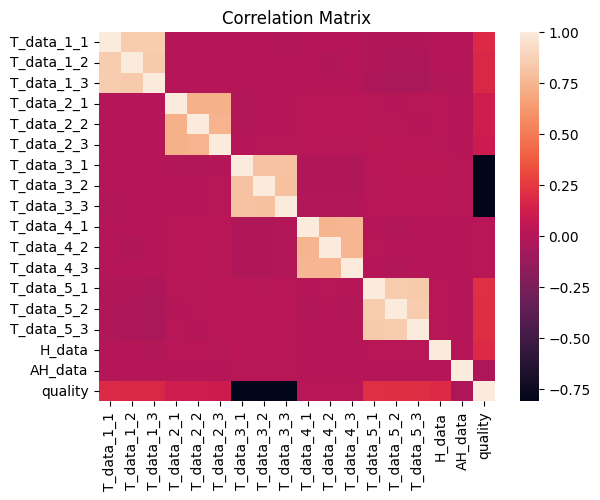

In [20]:
# Correlation Matrix

sns.heatmap(train.drop(columns=["date_time", "date_shifted"]).corr())
plt.title("Correlation Matrix")
# The stronges correlation is (of corse) between the set temperature and the temperature of the sensors.
# More interesting is that the temperature of chamber 3 has a relative high negative correlation with the quality of the product.
# -> (Reducing the set temperature of chamber 3 could increase the quality of the product)

Text(0.5, 1.0, 'Correlation of T3 with quality')

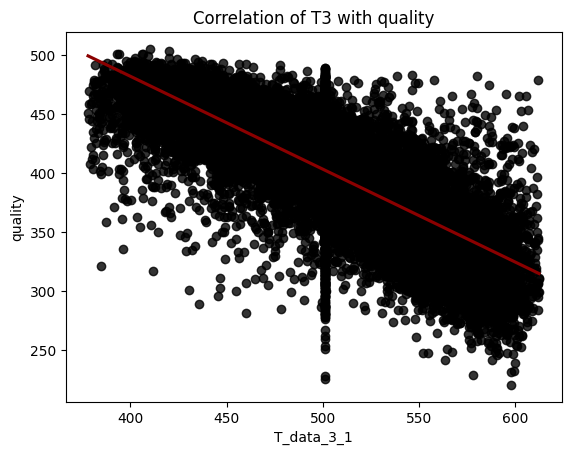

In [21]:
# Correlation of T3 with quality
sns.regplot(data=train, x="T_data_3_1", y="quality", scatter_kws={"color": "black"}, line_kws={"color": "darkred"})
plt.title("Correlation of T3 with quality")

<Axes: xlabel='T_data_1_1', ylabel='quality'>

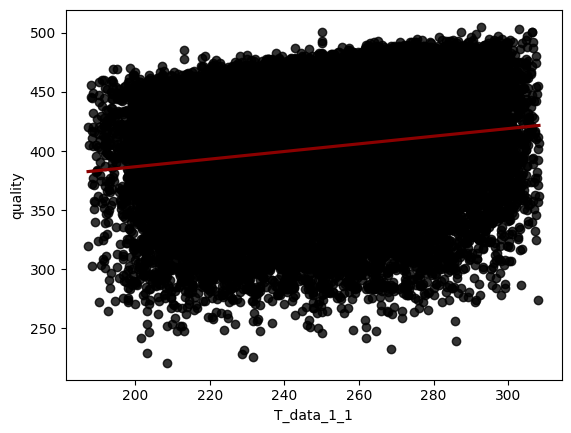

In [22]:
# Correlation of T1 with quality
sns.regplot(data=train, x="T_data_1_1", y="quality", line_kws={"color": "darkred"},scatter_kws={"color": "black"})


Text(0.5, 1.0, 'Correlation of AH with quality')

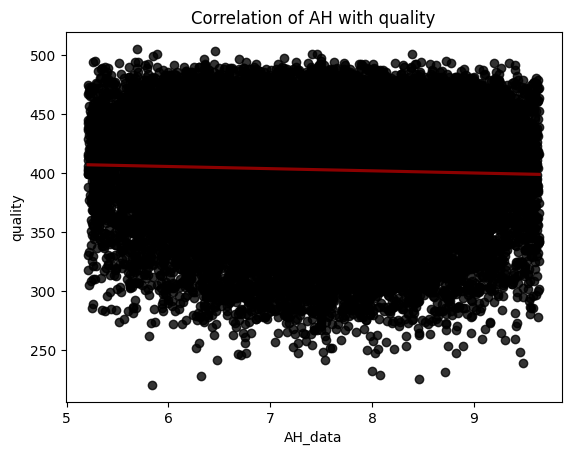

In [23]:
# Correlation of AH with quality
sns.regplot(data=train, x="AH_data", y="quality", line_kws={"color": "darkred"},scatter_kws={"color": "black"})
plt.title("Correlation of AH with quality")

# Machine Leaning Algorithm

In [24]:
# Import the libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import tree
from sklearn.model_selection import cross_val_score
import optuna
import xgboost as xgb

In a previous notebook, I followed the task's instructions to split the data as follows:
- **X + Y** = Training Data
- **X + S** = Testing Data

Given the unsatisfactory results, I decided to examine the model's performance using a test set derived from the training data. To do this, I further split the original training data into smaller training and validation sets:

- **X_Train + Y_Train**     = (Smaller) Training Data
- **X_Val + Y_Val**         = Validation/Test Data
- **X + S**                 = (True) Test Data

It's important to note that while these terms are typically associated with cross-validation or similar methods, in this case, they are being used differently. My approach was not aimed at performing cross-validation but rather at understanding the model's behavior by creating a validation set from the training data to benchmark the model's performance more accurately.

In [25]:
# Trein Test selection
X_train, y_train = train.drop(columns=["date_time", "date_shifted", "quality"]), train["quality"]
X_test, y_test = test.drop(columns=["date_time", "date_shifted", "quality"]), test["quality"]

In [26]:
# Train Test Split
X_train_smal, X_val, y_train_smal, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [27]:
# Linear Regression on Validation Set
model = LinearRegression()
model.fit(X_train_smal, y_train_smal)
y_pred = model.predict(X_val)
print("Linear Regression on Validation Set:")
print(f'MSE:{mean_squared_error(y_val, y_pred):.2f} \nMAE:{mean_absolute_error(y_val, y_pred):.2f}')

Linear Regression on Validation Set:
MSE:237.85 
MAE:11.40


In [28]:
# Linear Regression on Test Set
s_pred = model.predict(X_test)
print("Linear Regression on Test Set:")
print(f'MSE: {mean_squared_error(y_test, s_pred):.2f} \nMAE: {mean_absolute_error(y_test, s_pred):.2f}')

Linear Regression on Test Set:
MSE: 2225.51 
MAE: 38.85


In [29]:
# XGBoost on Validation Set
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model_xgb.fit(X_train_smal, y_train_smal)
y_pred = model_xgb.predict(X_val)
print("XGBoost on Validation Set:")
print(f'MSE:{mean_squared_error(y_val, y_pred):.2f} \nMAE:{mean_absolute_error(y_val, y_pred):.2f}')

XGBoost on Validation Set:
MSE:121.74 
MAE:8.01


In [30]:
# XGBoost on Test Set
s_pred = model_xgb.predict(X_test)
print("XGBoost on Validation Set:")
print(f'MSE:{mean_squared_error(y_test, s_pred):.2f} \nMAE:{mean_absolute_error(y_test, s_pred):.2f}')

XGBoost on Validation Set:
MSE:2307.61 
MAE:38.06


### Interpretation of the Results:

The Gradient Boosting Tree model slightly outperformed the Linear Regression model, but the results still fell short of initial expectations for prediction accuracy. 

The most significant observation is that the performance on the test set is considerably worse than on the validation set, which is typically a strong indication of overfitting. To address this, I explored several strategies:

- As mentioned earlier in the notebook, I tested the alternative data processing approach (using all data points), but the results were similarly suboptimal.
- I also implemented advanced machine learning techniques, including cross-validation and hyperparameter tuning. Despite these efforts, the results remained largely unchanged.

Given that these operations required several hours and did not improve the outcomes, I decided to proceed with option 1, as it provided equivalent value. However, since the issue persists, it suggests that the problem lies elsewhere. Therefore, it is necessary to take a closer look at the given data and results to identify the root cause.

In [31]:
# Get the Difference between the predicted and the actual quality
s_df = pd.DataFrame(s_pred, columns=["quality_pred"])
y_df = pd.DataFrame(y_test, columns=["quality"])
res_df = pd.concat([s_df, y_df], axis=1)

res_df["Delta"] = res_df["quality_pred"] - res_df["quality"]
print("Descriptive Statistics of the Delta:")
print(f'{res_df["Delta"].describe()}\n')
print("Descriptive Statistics of the raw/train quality-data:")
print(train["quality"].describe())


Descriptive Statistics of the Delta:
count    5808.000000
mean      -18.124634
std        44.490953
min      -163.637512
25%       -49.721313
50%       -12.726913
75%        17.274849
max        76.704254
Name: Delta, dtype: float64

Descriptive Statistics of the raw/train quality-data:
count    29184.000000
mean       402.800747
std         46.273228
min        221.000000
25%        372.000000
50%        408.000000
75%        439.000000
max        505.000000
Name: quality, dtype: float64


   quality_pred  quality      Delta
0    460.885529      420  40.885529
1    460.091248      420  40.091248
2    453.564667      420  33.564667
3    438.532715      420  18.532715
4    426.891235      420   6.891235


Text(0.5, 1.0, 'Delta of the predicted and the actual quality')

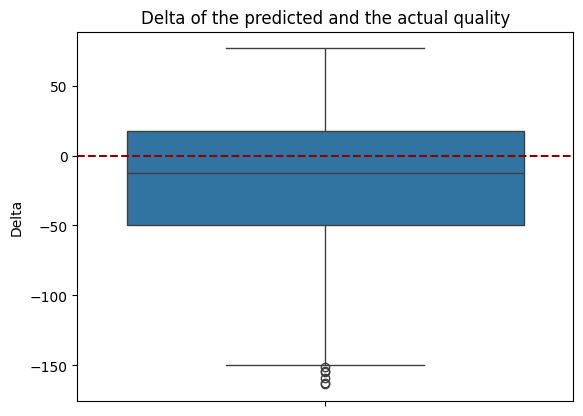

In [32]:
# Delta
print(res_df.head())
sns.boxplot(res_df["Delta"])
plt.axhline(y=0, color='Darkred', linestyle='--')
plt.title("Delta of the predicted and the actual quality")

# Conclusion:
We observed that the mean of the predicted values deviates by -18 points compared to the submission data. This discrepancy is likely explainable by the fact that the submission (test) dataset is synthetic and does not contain real quality samples. In the test data, all data points have a uniform quality value of 420, whereas the features follow the same patterns as in the training data, which has an average quality value of 402.

While this might seem like an overfitting issue, in this specific case, I would recommend not placing too much emphasis on the test data. The validation results, which are derived from real-world data, provide a much more accurate representation of actual conditions and should be considered the primary benchmark for evaluating model performance.

Furthermore, while the standard deviation of the validation data appears somewhat high, this is consistent with the observed variability in quality outcomes even when the temperature settings are identical. Given this context, I consider the results to be valid.

For more accurate predictions, I recommend incorporating additional features that could help narrow the variation in outcomes. Potential features might include variables such as "Supplier of Raw Material," "Storage Time," "Origin of the Material," and other relevant factors that could influence quality. By enriching the dataset with these types of features, we may be able to reduce variability and improve predictive accuracy.

# Recommendation - Next Steps

1. **Enhance Predictive Accuracy by Providing Additional Features:**
   - Introduce more relevant features, such as "Supplier of Raw Material," "Storage Time," and "Origin of the Material," to reduce variability and improve the model's accuracy.

2. **Reassess Overall Effectiveness to Identify Major Production Issues (Pareto Analysis):**
   - Implement KPI´s to monitore the Effectiveness of the Machine (OEE)
   - Take a step back and conduct a Pareto analysis to pinpoint the most significant issues impacting production. This will help prioritize areas with the highest potential for improvement.

3. **Implement a Predictive Quality System:**
   - If predictive quality remains the area with the greatest potential for enhancement, proceed with implementing a system focused on predictive quality to drive continuous improvement in production outcomes.

# Additional Analysis:
Given the strong correlation identified between the temperature in Chamber 3 and product quality, I conducted a simulation using the trained machine learning model to reverse-engineer the process parameters.

By leveraging the model's predictive capabilities, I iteratively adjusted the process temperatures for Chamber 3 across the entire dataset. This approach allowed us to generate a curve that illustrates the estimated average quality outcomes at various temperature settings.

This curve provides valuable insights into how different temperature adjustments in Chamber 3 could potentially optimize the quality of the produced batches.


In [33]:
# Use the trained model to predict the quality of the product for different set temperatures
dict_of_T3_to_quality = {}
for i in range(380,610,10):
    X_val["T_data_3_1"] = i
    X_val["T_data_3_2"] = i
    X_val["T_data_3_3"] = i
    y_pred = model_xgb.predict(X_val)
    dict_of_T3_to_quality[i] = y_pred.mean()
    print(f'Temperature: {i} -> Quality: {y_pred.mean():.2f}')

Temperature: 380 -> Quality: 471.05
Temperature: 390 -> Quality: 471.24
Temperature: 400 -> Quality: 472.13
Temperature: 410 -> Quality: 470.08
Temperature: 420 -> Quality: 466.24
Temperature: 430 -> Quality: 460.21
Temperature: 440 -> Quality: 454.37
Temperature: 450 -> Quality: 447.87
Temperature: 460 -> Quality: 441.22
Temperature: 470 -> Quality: 434.64
Temperature: 480 -> Quality: 424.94
Temperature: 490 -> Quality: 416.39
Temperature: 500 -> Quality: 409.22
Temperature: 510 -> Quality: 399.01
Temperature: 520 -> Quality: 388.93
Temperature: 530 -> Quality: 379.71
Temperature: 540 -> Quality: 368.42
Temperature: 550 -> Quality: 357.37
Temperature: 560 -> Quality: 347.32
Temperature: 570 -> Quality: 333.58
Temperature: 580 -> Quality: 319.00
Temperature: 590 -> Quality: 308.91
Temperature: 600 -> Quality: 303.64


Text(0.5, 1.0, 'Temperature of Chamber 3 to Quality of the Product')

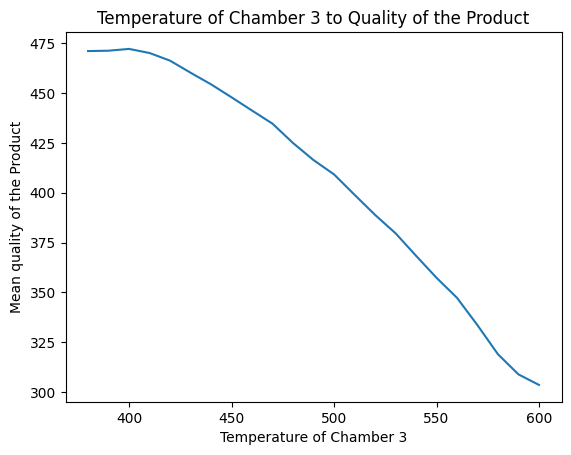

In [34]:
# Relationship between the temperature of chamber 3 and the quality of the product
sns.lineplot(x=dict_of_T3_to_quality.keys(), y=dict_of_T3_to_quality.values())
plt.xlabel("Temperature of Chamber 3")
plt.ylabel("Mean quality of the Product")
plt.title("Temperature of Chamber 3 to Quality of the Product")

In [35]:
import pickle
with open('model_xgb_quality_prediction.pkl', 'wb') as file:
    pickle.dump(model_xgb, file)